Ai club task for round 2

In [1]:
import kagglehub

path = kagglehub.dataset_download("orvile/ravdess-dataset")
print("Path to dataset files:", path)


Path to dataset files: /Users/myash/.cache/kagglehub/datasets/orvile/ravdess-dataset/versions/1


In [2]:
'''IMPORTING ALL THE LIBRARIES WE WILL USE'''
import librosa
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
import glob
import librosa.display
import IPython.display as ipd
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, confusion_matrix, classification_report
sns.set_theme(style = "white", palette = None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
audio_files = glob.glob(
    f"{path}/**/Audio_Speech_Actors_01-24/**/*.wav",
    recursive=True
)

print(len(audio_files))




1440


In [3]:
'''
Phase 1: Preprocessing & EDA
'''

#AUDIO CLEANING
def trim_silence(audio):
    """
    Removes silence from the beginning and end of an audio signal.
    """
    trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)
    return trimmed_audio


print("Completed Audio silence")

#Data Augmentation Functions
def add_white_noise(data):
    """
    Adds small random white noise to the signal.
    """
    noise = 0.002 * np.random.randn(len(data))
    return data + noise
print("Completed Adding white Noise")

def pitch_shift(data, sr):
    """
    Shifts pitch upward by 2 semitones.
    """
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=2)
print("Completed Pitch shift")
#Mel- Log Scale
def extract_log_mel_spectrogram(audio, sr):
    """
    Converts audio into a log-scaled Mel-Spectrogram.
    """
    # Generate Mel-Spectrogram (power scale)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels = 128)

    # Convert power spectrogram to decibel (log) scale
    log_mel_spec = librosa.power_to_db(mel_spec, ref = np.max, top_db = 80)

    return log_mel_spec

print("Completed extraction of log_mel_spectogram")

#Padding Function
def pad_spectrogram(spec, max_frames):
    if spec.shape[1] < max_frames:
        pad_width = max_frames - spec.shape[1]
        spec = np.pad(
            spec,
            ((0, 0), (0, pad_width)),
            mode="constant",
            constant_values=-80.0  # Change spec.min() to -80.0
        )
    else:
        spec = spec[:, :max_frames]
    return spec
def normalize_spec(spec):
    return (spec + 80) / 80   # scale from [-80,0] → [0,1]

print("Completed pad_spectogram")
frame_lengths = []

for file in audio_files:
    audio, sr = librosa.load(file, sr=22050)
    audio = trim_silence(audio)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    frame_lengths.append(mel.shape[1])

MAX_FRAMES = int(np.percentile(frame_lengths, 95))

print("MAX_FRAMES selected:", MAX_FRAMES)


#Full Processing for a single audio file
def process_audio_file(file_path):
    """
    Load → Trim → Augment → Log-Mel → Pad
    """
    audio, sr = librosa.load(file_path, sr=22050)
    audio = trim_silence(audio)

    # Original
    spec_orig = extract_log_mel_spectrogram(audio, sr)
    spec_orig = pad_spectrogram(spec_orig, MAX_FRAMES)
    spec_orig = normalize_spec(spec_orig)
   

    # White noise
    audio_noise = add_white_noise(audio)
    spec_noise = extract_log_mel_spectrogram(audio_noise, sr)
    spec_noise = pad_spectrogram(spec_noise, MAX_FRAMES)
    spec_noise = normalize_spec(spec_noise)

    # Pitch shift
    audio_pitch = pitch_shift(audio, sr)
    spec_pitch = extract_log_mel_spectrogram(audio_pitch, sr)
    spec_pitch = pad_spectrogram(spec_pitch, MAX_FRAMES)
    spec_pitch = normalize_spec(spec_pitch)

    return spec_orig, spec_noise, spec_pitch
print("Completed full batch audio processing")

#Batch Processing for a dataset folder

features = []
labels = []

for file in audio_files:
    # RAVDESS emotion label
    label = file.split("/")[-1].split("-")[2]

    specs = process_audio_file(file)

    for spec in specs:
        features.append(spec)
        labels.append(label)


#Getting CNN ready tensors
X = np.array(features)
y = np.array(labels)

# Add channel dimension for CNNs
X = X[..., np.newaxis]

print("X shape:", X.shape)  # (samples, mel, time, 1)
print("y shape:", y.shape)





Completed Audio silence
Completed Adding white Noise
Completed Pitch shift
Completed extraction of log_mel_spectogram
Completed pad_spectogram
MAX_FRAMES selected: 105
Completed full batch audio processing
X shape: (4320, 128, 105, 1)
y shape: (4320,)


In [ ]:
"""
Starting to develop CNN artitecture.
"""



le = LabelEncoder()
y_int = le.fit_transform(y)
y_cat = tf.keras.utils.to_categorical(y_int, num_classes=8)

X_train, X_temp, y_train, y_temp, y_int_train, y_int_temp = train_test_split(
    X, y_cat, y_int, test_size=0.2, stratify=y_int, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_int_temp, random_state=42
)


input_shape = X_train.shape[1:]   # (128, MAX_FRAMES, 1)


#Prepare data for training




#Create a convolutional neural network
model = tf.keras.models.Sequential([

    #Convoluthional layer. Learn 32 filters using a 3x3 kernel
    tf.keras.layers.Conv2D(32, (3,3), activation = "relu", input_shape = input_shape),
    tf.keras.layers.BatchNormalization(),
    #Max-pooling layer, using 2x2 pool size
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),


    tf.keras.layers.Conv2D(64, (3,3), activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),


    tf.keras.layers.Conv2D(128, (3,3), activation = "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    #Flatten units
    tf.keras.layers.Flatten(),

    #Add a hidden layer with dropout
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.Dropout(0.5),

    #Add an output layer units for all 10 digits
    tf.keras.layers.Dense(8, activation = "softmax")
])

model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

# Save best full model
best_model_cb = ModelCheckpoint(
    "model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Save best weights only
best_weights_cb = ModelCheckpoint(
    "best.weights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

data = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[best_model_cb, best_weights_cb]
)


#Evaluate neural network performace
model.evaluate(X_test, y_test, verbose = 2)

#Saving model
model.save("final_model.keras") 


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.1940 - loss: 4.8600
Epoch 1: val_loss improved from None to 7.64701, saving model to model.keras

Epoch 1: finished saving model to model.keras

Epoch 1: val_loss improved from None to 7.64701, saving model to best.weights.h5

Epoch 1: finished saving model to best.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 32s 282ms/step - accuracy: 0.2052 - loss: 2.9137 - val_accuracy: 0.1528 - val_loss: 7.6470
Epoch 2/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2189 - loss: 2.1056
Epoch 2: val_loss did not improve from 7.64701

Epoch 2: val_loss did not improve from 7.64701
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 276ms/step - accuracy: 0.2144 - loss: 2.1149 - val_accuracy: 0.1343 - val_loss: 18.6124
Epoch 3/3
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.2224 - loss: 1.9724
Epoch 3: val_loss did not improve from 7.64701

Epoch 3: val_loss did not improve from 7.64701
108/108 ━━━━━━━━━━━━━━━━━━━━ 31s 291ms/step - accur

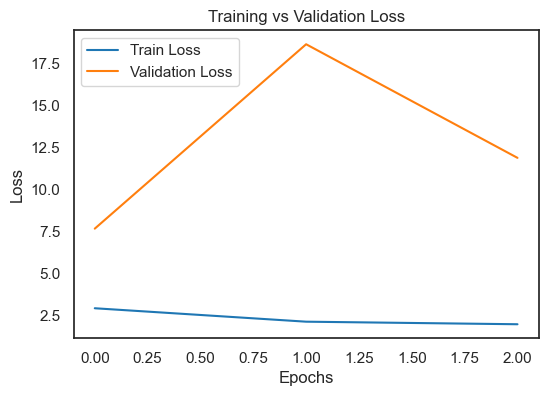

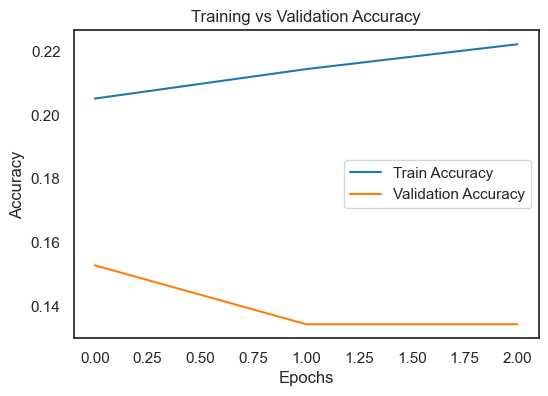

In [6]:

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(data.history['loss'], label='Train Loss')
plt.plot(data.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Accuracy curve
plt.figure(figsize=(6,4))
plt.plot(data.history['accuracy'], label='Train Accuracy')
plt.plot(data.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Macro F1-score: 0.02959183673469388


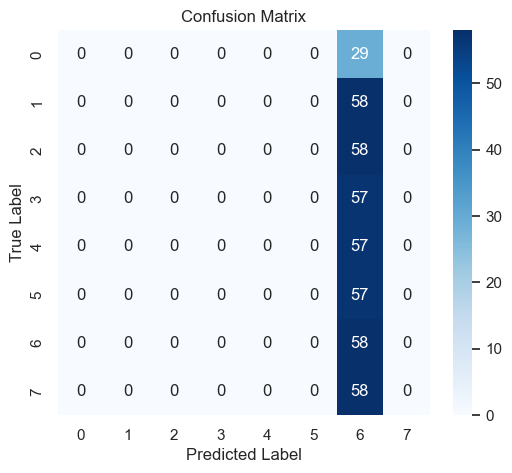


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        58
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00        57
           5       0.00      0.00      0.00        57
           6       0.13      1.00      0.24        58
           7       0.00      0.00      0.00        58

    accuracy                           0.13       432
   macro avg       0.02      0.12      0.03       432
weighted avg       0.02      0.13      0.03       432



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Predict class probabilities
y_pred_prob = model.predict(X_val)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert true labels (handle one-hot or integer labels)
y_true = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val

# Macro F1-score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro F1-score:", macro_f1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues'
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))
